# Chutes and Ladders
By: Liam Quinlan

---

## MonteCarlo Approach

In [64]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Setting up the Game

In [65]:
ladders = {1:38, 4:14, 9:31, 21:42, 36:44, 51:67, 71:91, 28:84, 80:100} # to climb closer to the goal
chutes = {16:6, 49:11, 47:26, 87:24, 56:53, 64:60, 93:73, 95:75, 98:78} # sets you farther away from the goal

init_state = 0

# create game map
game_map = {}

for i in range(101):
    if i not in ladders.keys() and i not in chutes.keys():
        game_map[i] = i

game_map.update(ladders)
game_map.update(chutes)

dice = {
    'RED': [2, 2, 2, 2, 6, 6],
    'BLUE': [3, 3, 3, 3, 3, 3],
    'GREEN': [1, 1, 1, 5, 5, 5],
    'BLACK': [0, 0, 4, 4, 4, 4]
}

In [66]:
def initFunctions2():
    policy = {state:'RED' for state in game_map.keys()}

    value = {}
    for state in game_map.keys():
        for action in dice.keys():
            value[(state, action)] = 0

    return policy, value

reward = -1
alpha = 0.1
epsilon = 0.05
gamma = 0.9

In [67]:
#======================================================
def update (s, a):
  '''
  params
  s = state int
  a = action int ex. 1

  returns
  final_state int
  reward int
  '''
  # select die
  outcomes = dice[a]

  # roll die
  spin = np.random.randint(0,6)
  spaces_to_move = outcomes[spin]

  # move piece
  new_state = s + spaces_to_move

  if new_state > 100:
    final_state = 100
  else:  
    # take chute or ladder, if needed
    final_state = game_map[new_state]

  reward = -1

  return final_state, reward

#======================================================
def trajectory(policy, value):
  '''
  Simulate one trajectory of experience
  Return list of states during trajectory
  '''
  traj = []
  state = 0
  i = 0

  while ( state < 100 and i < 100 ):
    action = selectAction(value, state)
    dice_roll = rollDice(action)

    if state + dice_roll > 100:
      new_state = 100
    else:
      new_state = game_map[state + dice_roll]

    s_prev = state
    state = new_state
    traj.append((s_prev,action,reward))
    i += 1

  return traj

#======================================================
def rollDice(dice_color):
    return random.choice(dice[dice_color])

#======================================================
def computePolicy(value):
    policy = {}
    for state in game_map.keys():
        opt_action = 'RED'
        for action in dice.keys():
            if value[(state, action)] > value[(state, opt_action)]:
                opt_action = action
        policy[state] = opt_action
    return policy

#======================================================
def selectAction(value, state):
    """
    Takes in the value function and the current state. Searches the value function's data
    for the action with the highest value. Returns that action
    """
    best_action = 'RED'
    for i, action in value.keys():
        if i == state and value[(i, action)] > value[(i, best_action)]:
            best_action = action
    if random.random() < epsilon:
        return random.choice(list(dice.keys()))
    else:
        return best_action

#======================================================
def monteCarlo(n):
  policy, value = initFunctions2()

  for i in range(n):
    # run trajectory
    traj = trajectory(policy, value)
    G = 0

    # iterate through trajectory and update Q values
    for t in reversed(range(len(traj))):
      state, action, reward = traj[t]

      G = reward + gamma * G
      
      value[(state, action)] += alpha * (G - value[(state, action)])

    # update policy function
    policy = computePolicy(value)

  return policy, value

In [68]:
def plot_value(data_dict):

    color_data = defaultdict(lambda: defaultdict(list))
    for (integer, color), number in data_dict.items():
        if number != -1 and number != 0:  # skip default values
            color_data[color]['x'].append(integer)
            color_data[color]['y'].append(number)
        # else:
        #     print(integer)

    plt.figure(figsize=(10, 6))

    for color, values in color_data.items():
        x_values = values['x']
        y_values = values['y']

        plt.plot(x_values, y_values, label=color, color=color)

    plt.xlabel('State')
    plt.ylabel('Value')
    plt.title('Value as a function of State given an Action')
    plt.legend(title="Actions")

    plt.show()

def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws in on the board"""
    grid = np.zeros((10, 10), dtype=int)

    #creates and numbers the base 1-100 grid
    number = 1
    for row in range(10):
        #logic to snake the numbers
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    #create 2d matrix of colors
    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  # Default to grey if not in policy
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # account for starting square 0. Placed it to the left of the 1st spot outside of the 10x10 grid
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(
        -0.5, 9.5, '0',
        color='white', ha='center', va='center', fontsize=8
    )

    # actually draw the grid
    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(
                col + 0.5, row + 0.5, str(grid[row, col]),
                color='white', ha='center', va='center', fontsize=8
            )

    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.gca().invert_yaxis()
    plt.show()

In [69]:
policy, value = initFunctions2()
traj = trajectory(policy, value)

{0: 'GREEN', 2: 'RED', 3: 'BLUE', 5: 'RED', 6: 'BLUE', 7: 'RED', 8: 'GREEN', 10: 'GREEN', 11: 'GREEN', 12: 'GREEN', 13: 'RED', 14: 'BLUE', 15: 'BLUE', 17: 'BLACK', 18: 'GREEN', 19: 'GREEN', 20: 'BLACK', 22: 'BLUE', 23: 'GREEN', 24: 'BLACK', 25: 'BLUE', 26: 'RED', 27: 'GREEN', 29: 'BLUE', 30: 'RED', 31: 'GREEN', 32: 'RED', 33: 'RED', 34: 'RED', 35: 'BLUE', 37: 'RED', 38: 'RED', 39: 'GREEN', 40: 'RED', 41: 'GREEN', 42: 'RED', 43: 'GREEN', 44: 'BLACK', 45: 'BLUE', 46: 'GREEN', 48: 'BLUE', 50: 'GREEN', 52: 'GREEN', 53: 'GREEN', 54: 'BLUE', 55: 'GREEN', 57: 'BLACK', 58: 'RED', 59: 'BLACK', 60: 'BLUE', 61: 'RED', 62: 'BLUE', 63: 'RED', 65: 'BLUE', 66: 'BLACK', 67: 'RED', 68: 'RED', 69: 'RED', 70: 'GREEN', 72: 'BLUE', 73: 'BLUE', 74: 'BLUE', 75: 'GREEN', 76: 'BLACK', 77: 'BLUE', 78: 'RED', 79: 'GREEN', 81: 'BLACK', 82: 'BLACK', 83: 'RED', 84: 'GREEN', 85: 'BLUE', 86: 'RED', 88: 'RED', 89: 'GREEN', 90: 'BLACK', 91: 'BLUE', 92: 'BLUE', 94: 'BLUE', 96: 'GREEN', 97: 'BLUE', 99: 'RED', 100: 'RED',

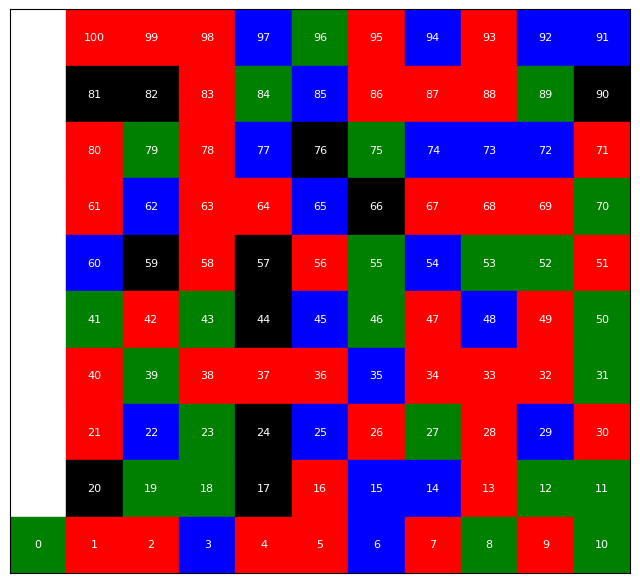

In [70]:
policy, value = monteCarlo(10000)

print(policy)

plot_policy(policy)